In [1]:
import numpy as np
import pandas as pd

from os.path import join
from os import makedirs
from glob import glob
import re

from tqdm import tqdm

import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import patches
from matplotlib import animation, rc

In [2]:
dir_behav = '/mnt/ext4/GL/behav_data'

In [3]:
dir_record = join(dir_behav, 'records')
makedirs(dir_record, exist_ok=True)

In [4]:
nn_list = ['03','04','05','06','07'
           , '08','09','10','11','12'
           , '14','15','16','17','18'
           , '19','20','21','22','24'
           , '25','26','27','29']

In [5]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

## Replay

In [6]:
tpr = 145
nrun = 6
sec = 4

In [7]:
subj = 'GL03'
nn = subj[2:]

datum = scipy.io.loadmat(join(dir_behav, '%s-fmri.mat'%subj))

# AM2 = np.loadtxt(
#     join(dir_reg, '%s_reward.txt'%subj)
#     , dtype=str, delimiter=' '
# )

In [8]:
sample_rate = 60*sec*tpr*nrun
print(sample_rate)

## target ID
tmp = datum['targetID']
targetID = tmp[tmp!=0][:tpr*nrun]

## box
bx = datum['boxSize']
pos = bx*convert_ID(targetID) # (posision, trial)

## cursor
allXY = datum['allXY']
assert allXY.shape == (2,sample_rate)

## frame
xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)

## is it hit?
tmp = np.zeros(allXY.shape)
for i in range(sample_rate):
    t = np.floor(i/(60*sec)).astype(int)
    tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]
err = allXY - tmp
hit = np.zeros(sample_rate)
for i in range(sample_rate):
    hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5

208800


#### Edit the window

In [9]:
# range_trial = np.arange(0,6)
range_trial = np.arange(145*4,145*4+6)

fpt = sec*60
range_frame = np.arange(range_trial[0]*fpt, (range_trial[-1]+1)*fpt)

targetID = targetID[range_trial]
pos = pos[:,range_trial]
allXY = allXY[:,range_frame]
hit = hit[range_frame]

sample_rate = range_frame[-1]-range_frame[0]+1

#### Frame

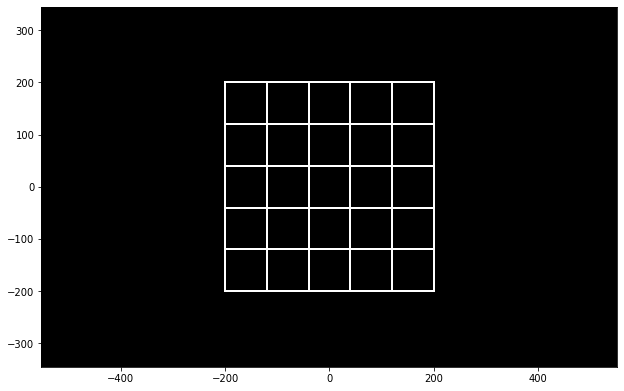

In [10]:
## 1440 * 900
ratio = [8, 5]

## Square
# ratio = [5, 5]

scale = 1
fig = plt.figure(figsize=ratio)
ax = plt.axes(xlim=np.array([-xFrame, xFrame])*ratio[0]/ratio[1]*scale, ylim=np.array([-yFrame, yFrame])*scale)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

## background
ax.set_facecolor((0., 0., 0.))

## grid
for x in [40, 120, 200]:
    for y in [40, 120, 200]:
        ax.plot([x,x], [-y,y], color='w', lw=2)
        ax.plot([-x,-x], [-y,y], color='w', lw=2)
        ax.plot([-x,x], [y,y], color='w', lw=2)
        ax.plot([-x,x], [-y,-y], color='w', lw=2)

live = []

In [11]:
def init():
    line, = ax.plot([], [], color='w', marker='+', markersize=12, lw=3)
    line.set_data([], [])
    
    target_unhit = patches.Rectangle([0, 0], 0, 0, fc='lightgray')
    target_hit = patches.Rectangle([0, 0], 0, 0, fc='crimson')
    
    live.append(line)
    live.append(ax.add_patch(target_unhit))
    live.append(ax.add_patch(target_hit))
    live.append(
        ax.text(
            -450, 200, '', ha='left', va='bottom'
            , fontsize=16, color='red', backgroundcolor='black'
        )
    )
    
    return live

In [12]:
## The anchor point (xy)
tmp = np.zeros(pos.shape)
tmp[0], tmp[1] = pos[0] - bx*.5, pos[1] - bx*.5

fpt = 60*sec

ap = np.zeros(allXY.shape)
for i in range(sample_rate):
    t = np.floor(i/fpt).astype(int)
    ap[0][i], ap[1][i] = tmp[0][t], tmp[1][t]

def animate(i):

    live[0].set_data(allXY[0, i], allXY[1, i])

    if hit[i]:
        live[1].set_width(0)
        live[1].set_height(0)
        live[1].set_xy([ap[0][i], ap[1][i]])
        
        live[2].set_width(bx)
        live[2].set_height(bx)
        live[2].set_xy([ap[0][i], ap[1][i]])
    else:
        live[1].set_width(bx)
        live[1].set_height(bx)
        live[1].set_xy([ap[0][i], ap[1][i]])
        
        live[2].set_width(0)
        live[2].set_height(0)
        live[2].set_xy([ap[0][i], ap[1][i]])
    
    fpt = 60*sec
    quotient = i//fpt
    remainder = i%fpt
    
    trial = quotient + 1
    tmp = hit[fpt*quotient:i].sum()
    touch = 0.0167 * tmp
    reward = tmp/fpt
    
    live[3].set_text('Trial: %d\nTime: %.2fs\nHit: %.2fs\nReward: %.3f'%(trial, 0.0167*i, touch, reward))

    return live

In [13]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=60*sec*6, interval=16.7, blit=True)

In [14]:
print('%s'%subj)

rc('animation', html='html5')
anim

GL03


/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [15]:
anim.save(
    join(dir_record,'%s.r04.t001-006.mp4'%subj)
    , writer = 'ffmpeg', fps=60
)

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
